# Topic 2 A - LDA Foundations (Binary case)

**Corresponding scripts:**:
 - `scripts/exercises/lda1.py`
 - `scripts/exercises/lda_over_data_ex2.py`
 - `scripts/exercises/lda_pred_ex3.py`

## Learning goals
- Understand what LDA is optimizing (class separation, not variance)
- Train an LDA classifier and evaluate it (test split + cross-validation)
- Use `transform()` to visualize the **LD1** projection in the 2-class case


In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

## 1) Create a labeled dataset (supervised setup)

LDA is **supervised**: it learns a projection using both:

- **X**: feature matrix with shape $n\_samples \times n\_features$
- **y**: labels (class of each sample)

We’ll start with a **binary** dataset (2 classes). This is important because:

$$
n\_{components}^{\max} = C - 1 = 1
$$

So in 2-class LDA, the best you can get is a **1D** representation: **LD1**.


In [2]:
X, y = make_classification(
    n_samples=1000,
    n_features=10,
    n_informative=10,
    n_redundant=0,
    n_classes=2,
    random_state=7
)

print("X shape:", X.shape)
print("Class counts:", np.bincount(y))

X shape: (1000, 10)
Class counts: [501 499]


## 2) Train/test split (generalization check)

We evaluate on unseen data to test **generalization**.

`stratify=y` keeps class proportions similar in both splits.


In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

print("Train shape:", X_train.shape)
print("Test shape :", X_test.shape)

Train shape: (700, 10)
Test shape : (300, 10)


## 3) Standardize features with `StandardScaler`

📌 Documentation:  
- [StandardScaler (scikit-learn)](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)

### Why scale?
LDA uses **means and covariance structure**. If features are in different units (e.g., EUR vs %),
large-scale features can dominate the covariance and distort the learned discriminant direction.

StandardScaler converts each feature into a **z-score**:

$$
z = \frac{x - \mu}{\sigma}
$$

- $x$ : original feature value
- $\mu$ : mean of the feature (learned from training data)
- $\sigma$ : standard deviation of the feature (learned from training data)

### What does `fit_transform()` mean?
`fit_transform(X_train)` is shorthand for:

1) `fit(X_train)` → learn \(\mu\) and \(\sigma\)  
2) `transform(X_train)` → apply the formula above

For the test set we do only:
- `transform(X_test)` (avoid leakage)


In [4]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# sanity check: mean ~0, std ~1 (approximately)
print("Mean (first 5 features):", X_train_scaled.mean(axis=0)[:5].round(3))
print("Std  (first 5 features):", X_train_scaled.std(axis=0)[:5].round(3))

Mean (first 5 features): [-0.  0.  0.  0.  0.]
Std  (first 5 features): [1. 1. 1. 1. 1.]


## 4) Fit LDA (classifier) + evaluate

LDA tries to find a direction \(w\) that separates classes as much as possible.

A classic 2-class intuition is Fisher’s criterion:

$$
J(w) = \frac{w^T S_B w}{w^T S_W w}
$$

- \(S_B\): between-class scatter (push class means apart)
- \(S_W\): within-class scatter (make each class tight)

In scikit-learn, `LinearDiscriminantAnalysis()` can be used directly as a **classifier**.


In [5]:
lda = LinearDiscriminantAnalysis()
lda.fit(X_train_scaled, y_train)

test_acc = lda.score(X_test_scaled, y_test)
print(f"Test accuracy: {test_acc:.3f}")

Test accuracy: 0.867


## 5) Cross-validation (stable estimate)

One split can be lucky/unlucky. Cross-validation estimates performance more robustly.

We use **RepeatedStratifiedKFold**:
- stratified → preserves class proportions in each fold
- repeated → repeats the process for stability


In [6]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
cv_scores = cross_val_score(lda, X, y, scoring="accuracy", cv=cv, n_jobs=-1)

print(f"CV accuracy: {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")
print("First 10 CV scores:", np.round(cv_scores[:10], 3))

CV accuracy: 0.827 ± 0.035
First 10 CV scores: [0.8  0.82 0.85 0.81 0.82 0.85 0.81 0.85 0.76 0.88]


## 6) Predict a single new observation

This mirrors the script exercise: we define a new row and ask the trained model to classify it.

Important: we must apply the **same scaler** used during training.


In [7]:
new_row = [0.12777556, -3.64400522, -2.23268854, -1.82114386, 1.75466361,
           0.1243966,  1.03397657,  2.35822076,  1.01001752,  0.56768485]

new_row_scaled = scaler.transform([new_row])
pred = lda.predict(new_row_scaled)[0]
print("Predicted class:", pred)

Predicted class: 0


## 7) Visual intuition: project to LD1

With 2 classes, LDA can produce only **one** discriminant axis:

$$
C - 1 = 1
$$

`transform()` returns the **LD scores** (coordinates in the discriminant space).
We can plot LD1 with histograms: less overlap → better separation.


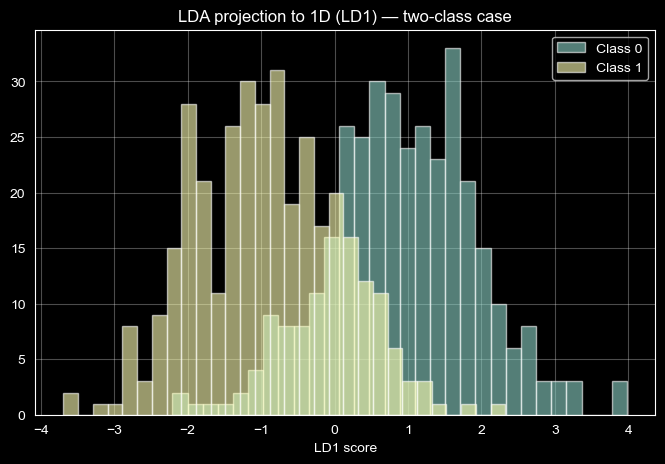

In [8]:
X_train_ld1 = lda.transform(X_train_scaled)  # shape: (n_train, 1)

plt.figure(figsize=(8, 5))
for cls in np.unique(y_train):
    plt.hist(X_train_ld1[y_train == cls, 0], bins=30, alpha=0.6, label=f"Class {cls}")

plt.xlabel("LD1 score")
plt.title("LDA projection to 1D (LD1) — two-class case")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## ✅ Interpretation of results (Topic 2A)

### 1) What the dataset tells us
- **X shape: (1000, 10)** means we have 1000 observations described by 10 features.
- **Class counts: [501, 499]** shows the dataset is **balanced** (almost 50/50).
  - Because classes are balanced, **accuracy** is a reasonable metric here (no strong bias toward one class).

---

### 2) What scaling confirms
After applying `StandardScaler`, we saw:
- feature means ≈ **0**
- feature standard deviations ≈ **1**

This matches the z-score transformation:

$$
z = \frac{x - \mu}{\sigma}
$$

Scaling matters because LDA relies on **means and covariance structure**; unscaled features with larger units could dominate the learned discriminant direction.

---

### 3) How to read the CV accuracy
We obtained:

- **CV accuracy ≈ 0.827 ± 0.035**

Interpretation:
- On average, the model classifies correctly about **82.7%** of the time.
- The **± 3.5%** spread reflects that different CV splits produce slightly different results (normal variation).

So the model is **reasonably strong**, but not perfect - and the variance indicates performance depends somewhat on how the data is split.

---

### 4) What the LD1 histogram means (the most important intuition)
In the 2-class case, LDA produces only **one** discriminant axis:

$$
n\_{components}^{\max} = C - 1 = 1
$$

So every sample becomes a single number: its **LD1 score**.

From the plot:
- the two class histograms are separated (good)
- but there is still a **visible overlap region** (inevitable mistakes)

📌 Key point:
> The overlap region explains why accuracy is ~0.83 and not close to 1.00.

Also:
- the **sign** of LD1 is arbitrary (the axis can flip), but separation stays the same.

---

### 5) What the single prediction means
`Predicted class: 0` simply means the new observation’s LD1 score lies on the side of the discriminant boundary associated with class 0.

If you want confidence, you can also check probabilities:

```python
lda.predict_proba(new_row_scaled)
```

---

### ✅ Final takeaway
- LDA found a **useful 1D projection (LD1)** with decent separation.
- The classes overlap enough that some errors are unavoidable (seen in both the histogram overlap and CV accuracy).
- This is the core idea of LDA: **reduce dimension while keeping class separation strong**.
